In [41]:
# 1. 필요한 라이브러리 임포트
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
import umap
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score
import matplotlib.pyplot as plt

In [42]:
# 2. 데이터 로드 및 스케일링
X_train = pd.read_csv('data/training_data/preprocessed_data.csv')
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)

# 3. PCA 적용 (차원 축소, 분산 비율 99.5%)
pca = PCA(n_components=0.995, random_state=123)
X_train_pca = pca.fit_transform(X_train_scaled)
print("Data form after PCA:", X_train_pca.shape)

Data form after PCA: (400, 371)


In [43]:
# 4. UMAP 적용 (차원을 10으로 축소)
umap_reducer = umap.UMAP(n_components=10, random_state=123)
X_train_umap = umap_reducer.fit_transform(X_train_scaled)
print("Data form after UMAP:", X_train_umap.shape)

c:\Users\danie\miniconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Data form after UMAP: (400, 10)


In [44]:
# 5. 최적의 eps 및 min_samples 찾기
eps_range = [i * 0.1 for i in range(1, 51)]  # 0.1부터 5.0까지
min_sample_range = range(2, 11)  # 2부터 10까지

best_eps = None
best_min_sample = None

for eps in eps_range:
    for min_sample in min_sample_range:
        dbscan = DBSCAN(eps=eps, min_samples=min_sample)
        dbscan_labels = dbscan.fit_predict(X_train_umap)
        unique_labels = set(dbscan_labels)
        
        # 목표 클러스터 수가 20개인 경우 최적의 값으로 설정
        if len(unique_labels) == 20:
            best_eps = eps
            best_min_sample = min_sample
            print(f"Optimal eps: {best_eps}, Optimal min_samples: {best_min_sample}")
            break
    if best_eps is not None:
        break


Optimal eps: 0.5, Optimal min_samples: 5


In [45]:
# 최적의 eps와 min_samples 값을 사용하여 DBSCAN 클러스터링 수행
dbscan = DBSCAN(eps=best_eps, min_samples=best_min_sample)
dbscan_labels = dbscan.fit_predict(X_train_umap)
unique_labels = set(dbscan_labels)
print("Final cluster labels after optimization:", unique_labels)

Final cluster labels after optimization: {np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17), np.int64(18), np.int64(-1)}


In [46]:
# 6. 클러스터 평가 (Silhouette Score와 Davies Bouldin Score)
if len(unique_labels) > 1:  # 적어도 2개의 클러스터가 있는 경우에만 평가
    silhouette_avg = silhouette_score(X_train_umap, dbscan_labels)
    davies_bouldin = davies_bouldin_score(X_train_umap, dbscan_labels)
    print(f'Silhouette Score: {silhouette_avg}')
    print(f'Davies Bouldin Score: {davies_bouldin}')
else:
    print("Not enough clusters to evaluate.")


Silhouette Score: 0.37862488627433777
Davies Bouldin Score: 0.928984994373342


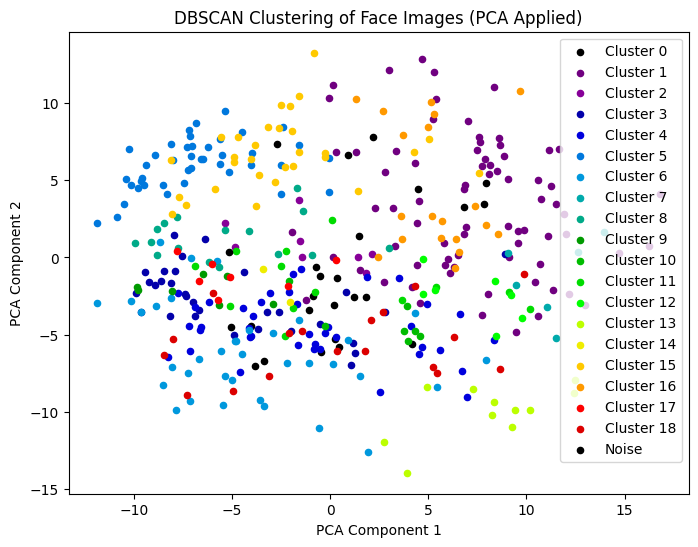

In [47]:
# 7. 클러스터 시각화 (PCA 적용 데이터)
plt.figure(figsize=(8, 6))
for label in unique_labels:
    if label == -1:
        color = 'black'  # 노이즈는 검은색으로 표시
        label_name = 'Noise'
    else:
        color = plt.cm.nipy_spectral(float(label) / len(unique_labels))
        label_name = f'Cluster {label}'
    
    mask = (dbscan_labels == label)
    plt.scatter(X_train_pca[mask, 0], X_train_pca[mask, 1], c=[color], label=label_name, s=20)

plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('DBSCAN Clustering of Face Images (PCA Applied)')
plt.legend()
plt.show()


In [48]:
# 8. 검증 및 테스트 데이터에 파이프라인 적용
X_val = pd.read_csv("data/validation_data/umist_val_for_cluster.csv")
X_test = pd.read_csv("data/test_data/umist_test_for_cluster.csv")

# 검증 데이터에 스케일링과 PCA 적용
X_val_scaled = scaler.transform(X_val)
X_val_pca = pca.transform(X_val_scaled)

# 최적의 DBSCAN 설정으로 검증 데이터 클러스터링
dbscan_labels_val = dbscan.fit_predict(X_val_pca)
print("Validated data DBSCAN Label:", set(dbscan_labels_val))

Validated data DBSCAN Label: {np.int64(-1)}
